C:\Users\ML\AppData\Local\Temp\ipykernel_13204\616994943.py:15: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(image)


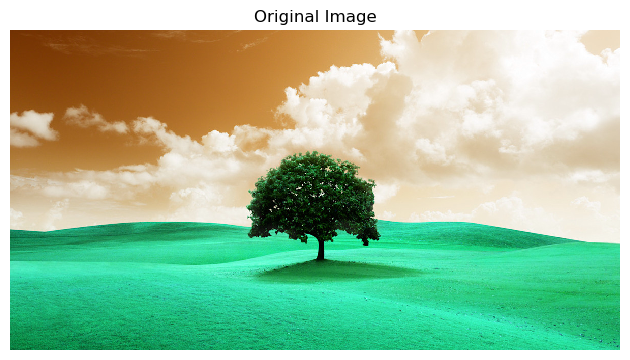

In [3]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_uint
from skimage.io import imshow, imread
from skimage.color import rgb2hsv
from skimage.color import rgb2gray
from skimage.color import rgb2ycbcr


image = cv2.imread(r"C:\Users\ML\Desktop\123B1F033\nature.jpg")
plt.title("Original Image")
plt.axis("off")
imshow(image)

C:\Users\ML\AppData\Local\Temp\ipykernel_13204\1819902070.py:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(gray)


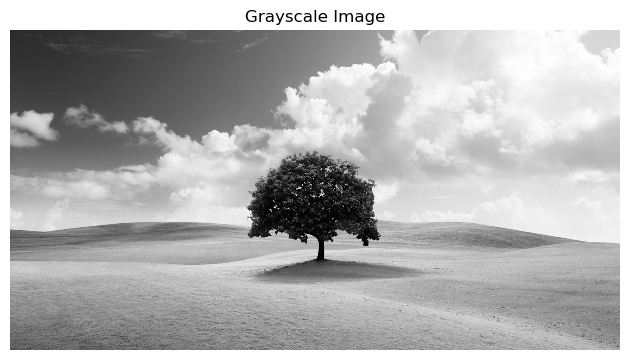

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.title("Grayscale Image")
plt.axis("off")
imshow(gray)

C:\Users\ML\AppData\Local\Temp\ipykernel_13204\1778891671.py:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(ycbcr)


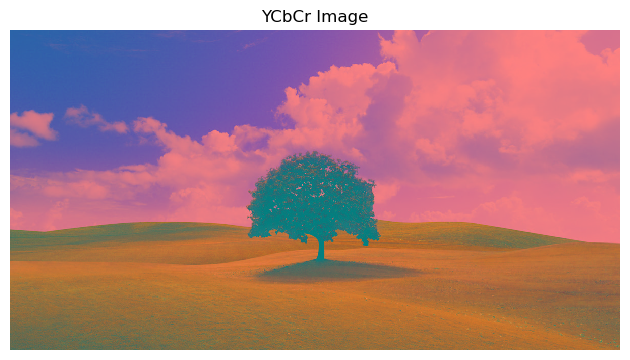

In [11]:
ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
plt.title("YCbCr Image")
plt.axis("off")
imshow(ycbcr)

C:\Users\ML\AppData\Local\Temp\ipykernel_13204\3433862404.py:80: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(compressed_image)


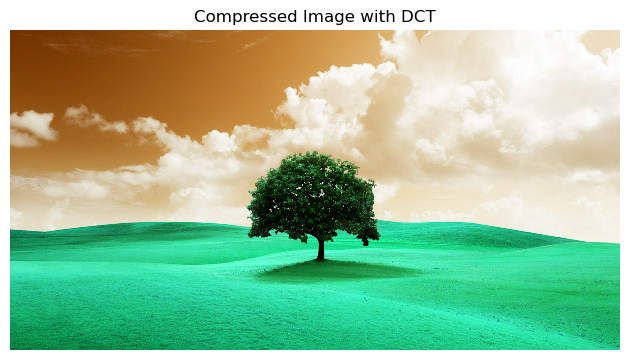

In [13]:
import cv2
import numpy as np
from scipy.fftpack import dct, idct

def dct2d(a):
    """Performs 2D DCT on a block."""
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def idct2d(a):
    """Performs 2D Inverse DCT on a block."""
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

def compress_image_dct_ycbcr(image, quality=50, block_size=8):

    # 1. convert to YCbCr
    img_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # Note: OpenCV uses YCrCb, not YCbCr

    # 2. Prepare quantization matrix (example for JPEG-like compression)
    # A simple example; real JPEG uses more complex matrices
    quantization_matrix = np.ones((block_size, block_size)) * (100 - quality) / 10 + 1
    quantization_matrix[0, 0] = 1 # DC coefficient often less quantized

    compressed_channels = []
    for i in range(3): # Process Y, Cb, Cr channels
        channel = img_ycbcr[:, :, i].astype(np.float32)

        # Pad the image if dimensions are not multiples of block_size
        h, w = channel.shape
        padded_h = int(np.ceil(h / block_size)) * block_size
        padded_w = int(np.ceil(w / block_size)) * block_size
        padded_channel = np.zeros((padded_h, padded_w))
        padded_channel[:h, :w] = channel

        transformed_channel = np.zeros_like(padded_channel)

        # 3. Apply DCT to 8x8 blocks, quantize, and store
        for r in range(0, padded_h, block_size):
            for c in range(0, padded_w, block_size):
                block = padded_channel[r:r+block_size, c:c+block_size]
                # Shift pixel values from [0, 255] to [-128, 127] for DCT
                shifted_block = block - 128
                dct_block = dct2d(shifted_block)
                quantized_block = np.round(dct_block / quantization_matrix)
                transformed_channel[r:r+block_size, c:c+block_size] = quantized_block
        
        compressed_channels.append(transformed_channel)

    # 4. Reconstruct the image (for demonstration of compression effect)
    reconstructed_channels = []
    for i in range(3):
        transformed_channel = compressed_channels[i]
        reconstructed_channel = np.zeros_like(transformed_channel)

        for r in range(0, padded_h, block_size):
            for c in range(0, padded_w, block_size):
                quantized_block = transformed_channel[r:r+block_size, c:c+block_size]
                # De-quantize
                dequantized_block = quantized_block * quantization_matrix
                idct_block = idct2d(dequantized_block)
                # Shift back pixel values
                reconstructed_block = idct_block + 128
                reconstructed_channel[r:r+block_size, c:c+block_size] = reconstructed_block
        
        reconstructed_channels.append(reconstructed_channel[:h, :w]) # Remove padding

    reconstructed_ycbcr = np.stack(reconstructed_channels, axis=-1)
    reconstructed_ycbcr = np.clip(reconstructed_ycbcr, 0, 255).astype(np.uint8)
    reconstructed_bgr = cv2.cvtColor(reconstructed_ycbcr, cv2.COLOR_YCrCb2BGR)

    return reconstructed_bgr

# Example usage:
image= cv2.imread(r"C:\Users\ML\Desktop\123B1F033\nature.jpg")# Replace with your image path
output_image_path = 'compressed_image.jpg'

compressed_image = compress_image_dct_ycbcr(image, quality=30)

plt.title("Compressed Image with DCT")
plt.axis("off")
imshow(compressed_image)